In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')
print(f'training N: {len(data_df)}')
data_df.head()

training N: 45778


,training_set,ct,y,x
0,True,1,0,AAATTTACACTTTATGCATCAGACTCGTATGTTGTGTGG
1,False,1,0,AACTTAACAATTTATGCTTCCGACTCGTATATTCTGTGG
2,True,1,0,AACTTTACACTATATGCGTCAGGCTCGTATGTTGTGTGG
3,False,1,0,AACTTTACACTGTATGCTTCCGTCTCCTATGTTGTGTGG
4,False,2,0,AACTTTACACTTGATGCTTCCGGCTCGTATGTTGTGTAG


In [3]:
ix = data_df['training_set']
train_df = data_df[ix].reset_index(drop=True)
test_df = data_df[~ix].reset_index(drop=True)
L = len(train_df['x'][0])
L

39

In [4]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
Y = len(set(data_df['y']))
print(f'L={L}, Y={Y}')

# Split into training and test data
ix = data_df['training_set']
training_df = data_df[ix].copy()
training_df.reset_index(inplace=True)
test_df = data_df[~ix].copy()
test_df.reset_index(inplace=True)
print(f'N training: {len(training_df)/Y:,.0f}')
print(f'N test: {len(test_df)/Y:,.0f}')

L=39, Y=10
N training: 3,652
N test: 926


In [5]:
refit_model = False
if refit_model:

    # Set seeed
    mavenn.set_seed(0)

    # Define model
    model = mavenn.Model(regression_type='MPA',
                         L=L,
                         Y=Y,
                         alphabet='dna',
                         gpmap_type='additive',
                         na_hidden_nodes=50,
                         eta_regularization=0.01,
                         theta_regularization=0.01,
                         )

    # Where is ct_n?
    model.set_data(x=training_df['x'],
                   y=training_df['y'],
                   ct_n=training_df['ct'])

    # Fit model to data
    history = model.fit(learning_rate=.005,
                        epochs=1000,
                        early_stopping=True,
                        early_stopping_patience=10)

    # Save model
    model.save('sortseq_mpa_additive')

In [6]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


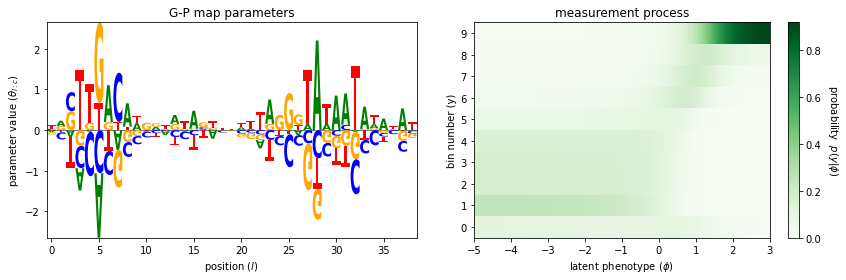

In [7]:
# Get G-P map parameters
theta_dict = model.get_theta(gauge='uniform')

# Get additive parameters suitable for logomaker
theta_logomaker_df = theta_dict['logomaker_df']

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta_logomaker_df, ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()

I_pred_test: 0.413 +- 0.014 bits
I_like_test: 0.329 +- 0.008 bits


Text(0, 0.5, 'bits')

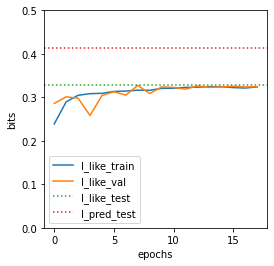

In [8]:
# Compute predictive information on test data
I_pred_test, dI_pred_test =  model.I_predictive(x=test_df['x'], 
                                          y=test_df['y'], 
                                          ct=test_df['ct'])
print(f'I_pred_test: {I_pred_test:.3f} +- {dI_pred_test:.3f} bits') 

# Compute loss information on test data
I_like_test, dI_like_test =  model.I_likelihood(x=test_df['x'], 
                                          y=test_df['y'], 
                                          ct=test_df['ct'])
print(f'I_like_test: {I_like_test:.3f} +- {dI_like_test:.3f} bits') 

# Get loss information history
I_like = model.history['I_like']
val_I_like = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like, label='I_like_train')
ax.plot(val_I_like, label='I_like_val')
ax.set_ylim([0,.5])
ax.axhline(I_like_test, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred_test, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

In [9]:
N = int(test_df['ct'].sum())
print(f'Simulation N: {N}')
sim_df = model.simulate_dataset(N)
sim_df

Simulation N: 12349


,training_set,phi,y,ct,x
0,True,0.735428,8,13,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
1,True,0.735428,9,11,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
2,True,0.735428,7,11,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
3,True,0.735428,0,8,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
4,True,0.735428,6,6,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
...,...,...,...,...,...
12186,True,-0.383148,9,1,GGCTTCACACTTTATGCGTCCGGCTCGTATGTTGGGCGG
12187,False,-0.169698,2,1,GGCTTCACACTTTATGCTACCGGCTCGTATGTTGTGTGG
12188,False,-0.000520,1,1,GGCTTCACACTTTATGCTACTGGCGCATATGTTGTGTGG
12189,False,0.367282,7,1,GGCTTCACACTTTATGCTGCCGGTTTGTATGCTGTTTGG


In [10]:
sim_df.sort_values(by='ct', inplace=True, ascending=False)
sim_df

,training_set,phi,y,ct,x
0,True,0.735428,8,13,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
2,True,0.735428,7,11,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
1,True,0.735428,9,11,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
3,True,0.735428,0,8,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
4,True,0.735428,6,6,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
...,...,...,...,...,...
4129,True,-0.653555,4,1,TGCTTTAGACTTTTTTGTTCCGGCTCGTATGTTGTGTGG
4130,True,0.521524,6,1,TGCTTTAGAGTTTATGTTTCTGGCTGGTATGTTGTGCGG
4131,True,-1.156647,2,1,TGCTTTACTCTTTATGCGTCCGGCTCGTTGGTTATGTGG
4132,True,0.524138,4,1,TGCTTTACTCTTTATGCCTCCGACTCGTATGGTGTGTGG
